<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/pursuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teorie pronásledování

Teorie pronásledování popisuje situaci, kdy jeden objekt uniká druhému. Schopnost uniknout či schopnost dostihnout jsou závislé na mnoha atributech. V prvotním úsudku je jasné, že rozhodující bude vzájemná rychlost. Jestliže unikající bude mít vyšší rychlost a prostředí je homogenní, tedy neovlivňuje rychlost, stíhající unikajícího nikdy nedostihne. Naopak ve stejném prostředí, pokud rychlost unikajícího je menší než stíhajícího, stíhající unikajícího dostihne. A nic na tom nezmění ani Ezopova bajka Zajíc a želva [zde](https://cs.wikisource.org/wiki/Bajky_Lafont%C3%A9novy/Zaj%C3%ADc_a_%C5%BEelva) ani starořecký paradox Achiles a želva [zde](https://cs.wikipedia.org/wiki/Achilles_a_%C5%BEelva), prapůvod integrálního počtu.

Bude-li prostředí heterogenní, je situace daleko složitější. V heterogenním prostředí existují překážky, s jejichž pomocí může unikající efektivně provádět manévr a prodlužovat čas střetu i za předpokladu, že jeho rychlost je menší, než rychlost stíhajícího.

Nezanedbatelným aspektem jsou energetické nároky a schopnosti manévru. Oba tyto atributy mohou přispět ke vzniku situací, kdy unikající s menší rychlostí není nikdy dostižen.

Pro zkoumání tohoto konfliktu lze použít mnohé metody operační analýzy. Teorie her a dynamické programování jsou dvě z nich. 

V tomto textu provedeme několik simulačních experimentů, které dají přehled o základních scénařích.

## Nevyhnutelné importy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

#smallImages = False
smallImages = True
if smallImages:
  plt.rcParams["font.size"] = "10"
  plt.rcParams["figure.figsize"] = (15, 10)
else:
  plt.rcParams["font.size"] = "18"
  plt.rcParams["figure.figsize"] = (25, 24)

## Zobrazení datových výstupů

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


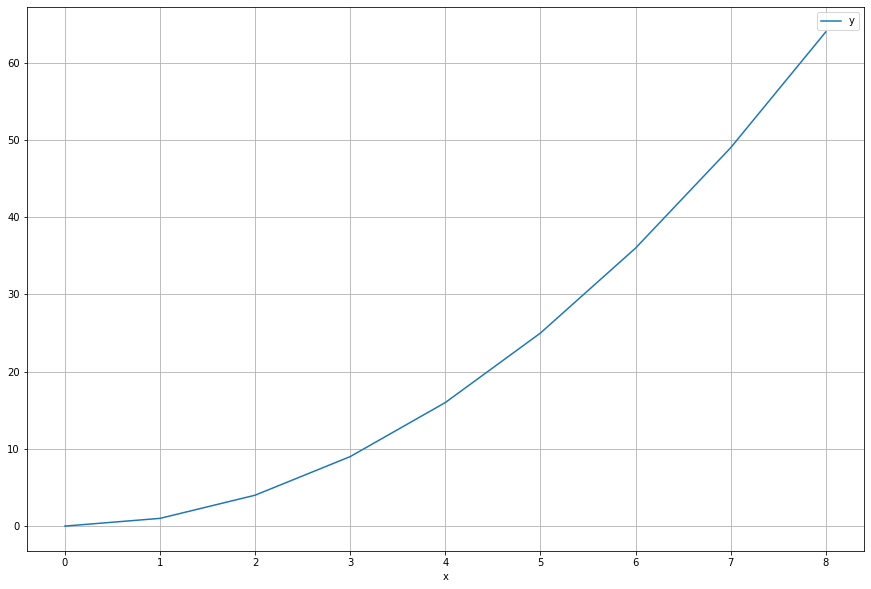

In [ ]:
def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
plt.grid(which='both')
displayData(data)

## Pomocné funkce

In [ ]:
def Vector(*args):
  return np.array(args)

In [ ]:
def multimap(generator, **maps):
  for item in generator:
    result = {}
    for key, func in maps.items():
      result[key] = func(item)
    yield result

In [ ]:
def take(generator, count = 100):
  for index, item in enumerate(generator):
    if index == count: 
      break
    yield item

In [ ]:
def select(generator, name):
  for item in generator:
    yield item[name]

In [ ]:
def untilPlusOne(generator, f):
  for item in generator:
    yield item
    if f(item):
      break

## Pronásledovaný

In [ ]:
def createRunner(position, velocity, t0 = 0, dt = 1):
  def runner():
    currentTime = t0
    currentPosition = position
    while True:
      yield {'t': currentTime, 'rpos': currentPosition}
      currentPosition = currentPosition + dt * velocity
      currentTime = currentTime + dt
  return runner

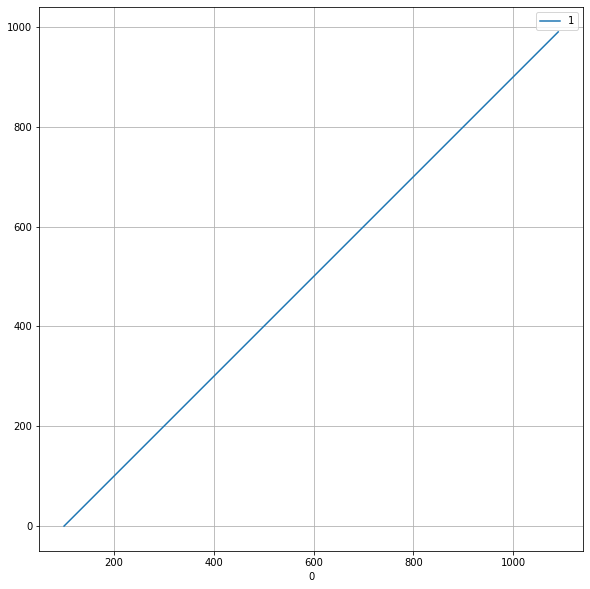

In [ ]:
myRunner = createRunner(Vector(100, 0), Vector(10, 10))
results = take(select(myRunner(), 'rpos'), 100)
plotData(results)
plt.grid(which = 'both')  
plt.gca().set_aspect('equal')

## Pronásledující

In [ ]:
def createFollower(position, v0, t0 = 0, resultName = 'fpos'):
  def follower(runner):
    currentPosition = position
    currentTime = t0
    #currentVelocity = v0
    for state in runner:
      runnerPosition = state['rpos']
      runnerTime = state['t']

      deltaTime = runnerTime - currentTime
      headToRunner = runnerPosition - currentPosition
      headToRunnerAbs = np.linalg.norm(headToRunner)
      
      velocity = headToRunner / headToRunnerAbs * v0
      currentPosition = currentPosition + deltaTime * velocity
      yield {**state, resultName: currentPosition}

      currentTime = runnerTime

  return follower

,t,rx,ry,fx,fy
0,0.0,100.0,0.0,0.000000,0.000000
1,0.1,101.0,1.0,1.999902,0.019801
2,0.2,102.0,2.0,3.999510,0.059397
3,0.3,103.0,3.0,5.998628,0.118777
4,0.4,104.0,4.0,7.997062,0.197922
...,...,...,...,...,...
145,14.5,245.0,145.0,243.013106,143.014850
146,14.6,246.0,146.0,244.427733,144.428651
147,14.7,247.0,147.0,245.842199,145.842612
148,14.8,248.0,148.0,247.256548,147.256690


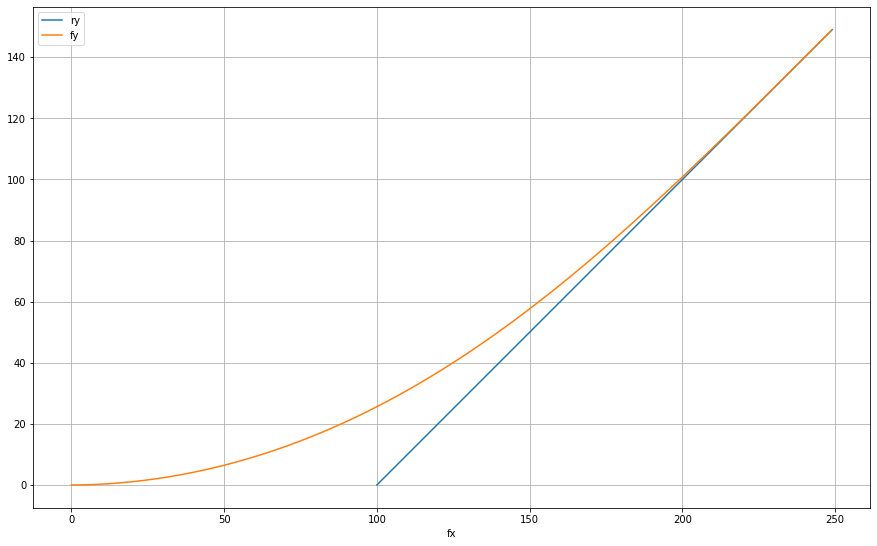

In [ ]:
myRunner = createRunner(Vector(100, 0), Vector(10, 10), dt = 0.1)
myFollower = createFollower(Vector(0, 0), 20)

maps = {
    't': lambda item: item['t'],
    'rx': lambda item: item['rpos'][0],
    'ry': lambda item: item['rpos'][1],
    'fx': lambda item: item['fpos'][0],
    'fy': lambda item: item['fpos'][1]
    }

results = list(take(multimap(myFollower(myRunner()), **maps), 150))
displayData(results)

ax = plotData(results, 'rx', 'ry')
ax = plotData(results, 'fx', 'fy', ax = ax)
plt.grid(which = 'both')  
plt.gca().set_aspect('equal')

## Rozhodčí (test střetu)

In [ ]:
def createJudge(distanceLimit = 10, runnerName = 'rpos', followerName = 'fpos', jName = 'judgement'):
  def judge(dataSequence):
    for item in dataSequence:
      distance = np.linalg.norm(item[runnerName] - item[followerName])
      result = distance <= distanceLimit
      yield {**item, jName: result}
  return judge

In [ ]:
def experiment(runnerPos, runnerVelocity, followerPos, followerVelocity):
  myRunner = createRunner(runnerPos, runnerVelocity, dt = 0.1)
  myFollower = createFollower(followerPos, followerVelocity)
  myJudge = createJudge(distanceLimit = 5)

  results = untilPlusOne(myJudge(myFollower(myRunner())), lambda item: item['judgement'])
  #results = myJudge(myFollower(myRunner()))
  litem = {}
  for item in results:
    litem = item
  return litem

print(experiment(Vector(100, 0), Vector(10, 10), Vector(0, 0), 20))

{'t': 14.199999999999966, 'rpos': array([242., 142.]), 'fpos': array([238.76777382, 138.77490287]), 'judgement': True}


## Appoloniova křivka (jeden pronásledující)

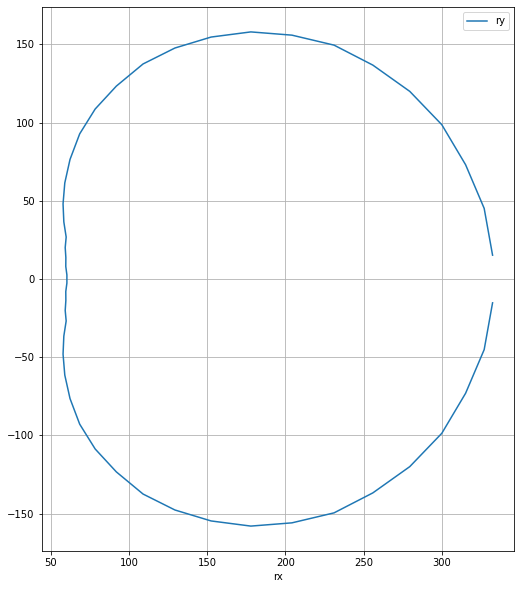

In [ ]:
from math import sin, cos, pi

def multiExperiment(runnerPos, runnerVelocity, followerPos, followerVelocity):
  count = 48
  deltaAngle = 2 * pi / count
  deltaAngle2 = deltaAngle / 2
  for index in range(count):
    currentAngle = index * deltaAngle + deltaAngle2
    currentVelocity = Vector(runnerVelocity * cos(currentAngle), runnerVelocity * sin(currentAngle))
    meetingPoint = experiment(runnerPos, currentVelocity, followerPos, followerVelocity)
    yield meetingPoint


results = list(multimap(multiExperiment(Vector(100, 0), 14.2, Vector(0, 0), 20), **maps))
ax = plotData(results, 'rx', 'ry')
plt.grid(which = 'both')  
plt.gca().set_aspect('equal')

## Appoloniova křivka (dva pronásledující)

,t,rx,ry,fxA,fyA,fxB,fyB
0,0.0,100.0,0.0,0.000000,50.000000,0.000000,-50.000000
1,0.1,101.0,1.0,1.799416,49.127016,1.785305,-49.098509
2,0.2,102.0,2.0,3.609236,48.275809,3.567055,-48.190012
3,0.3,103.0,3.0,5.429291,47.446713,5.345245,-47.274566
4,0.4,104.0,4.0,7.259403,46.640060,7.119869,-46.352227
...,...,...,...,...,...,...,...
124,12.4,224.0,124.0,218.859275,118.931589,197.365398,98.645444
125,12.5,225.0,125.0,220.281840,120.337401,198.812735,100.025739
126,12.6,226.0,126.0,221.702941,121.744694,200.258840,101.407325
127,12.7,227.0,127.0,223.122739,123.153301,201.703741,102.790170


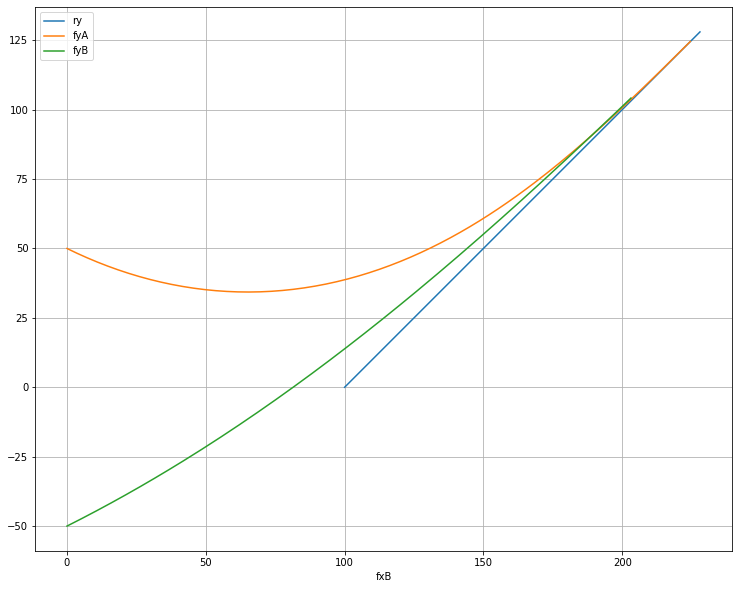

In [ ]:
maps = {
    't': lambda item: item['t'],
    'rx': lambda item: item['rpos'][0],
    'ry': lambda item: item['rpos'][1],
    'fxA': lambda item: item['fposA'][0],
    'fyA': lambda item: item['fposA'][1],
    'fxB': lambda item: item['fposB'][0],
    'fyB': lambda item: item['fposB'][1],
    }


def experiment2(runnerPos, runnerVelocity, followerPosA, followerPosB, followerVelocity):
  myRunner = createRunner(runnerPos, runnerVelocity, dt = 0.1)
  myFollowerA = createFollower(followerPosA, followerVelocity, resultName='fposA')
  myFollowerB = createFollower(followerPosB, followerVelocity, resultName='fposB')
  myJudgeA = createJudge(distanceLimit = 5, jName = 'judgementA', followerName='fposA')
  myJudgeB = createJudge(distanceLimit = 5, jName = 'judgementB', followerName='fposB')


  followersWithRunner = myFollowerB(myFollowerA(myRunner()))
  withJudges = myJudgeB(myJudgeA(followersWithRunner))

  results = untilPlusOne(withJudges, lambda item: (item['judgementA'] != False) | (item['judgementB'] != False))
  return results

results = list(multimap(experiment2(Vector(100, 0), Vector(10, 10), Vector(0, 50), Vector(0, -50), 20), **maps))
displayData(results)
ax = plotData(results, 'rx', 'ry')
ax = plotData(results, 'fxA', 'fyA', ax = ax)
ax = plotData(results, 'fxB', 'fyB', ax = ax)
plt.grid(which = 'both')  
plt.gca().set_aspect('equal')

In [ ]:
def experiment2(runnerPos, runnerVelocity, followerPosA, followerPosB, followerVelocity):
  myRunner = createRunner(runnerPos, runnerVelocity, dt = 0.1)
  myFollowerA = createFollower(followerPosA, followerVelocity, resultName='fposA')
  myFollowerB = createFollower(followerPosB, followerVelocity, resultName='fposB')
  myJudgeA = createJudge(distanceLimit = 5, jName = 'judgementA', followerName='fposA')
  myJudgeB = createJudge(distanceLimit = 5, jName = 'judgementB', followerName='fposB')


  followersWithRunner = myFollowerB(myFollowerA(myRunner()))
  withJudges = myJudgeB(myJudgeA(followersWithRunner))

  results = untilPlusOne(withJudges, lambda item: (item['judgementA'] != False) | (item['judgementB'] != False))
  #results = myJudge(myFollower(myRunner()))
  litem = {}
  for item in results:
    litem = item
  return litem

print(experiment2(Vector(100, 0), Vector(10, 10), Vector(0, 50), Vector(0, -50), 20))


{'t': 12.79999999999997, 'rpos': array([228., 128.]), 'fposA': array([224.54139022, 124.56306257]), 'fposB': array([203.14746415, 104.17424522]), 'judgementA': True, 'judgementB': False}


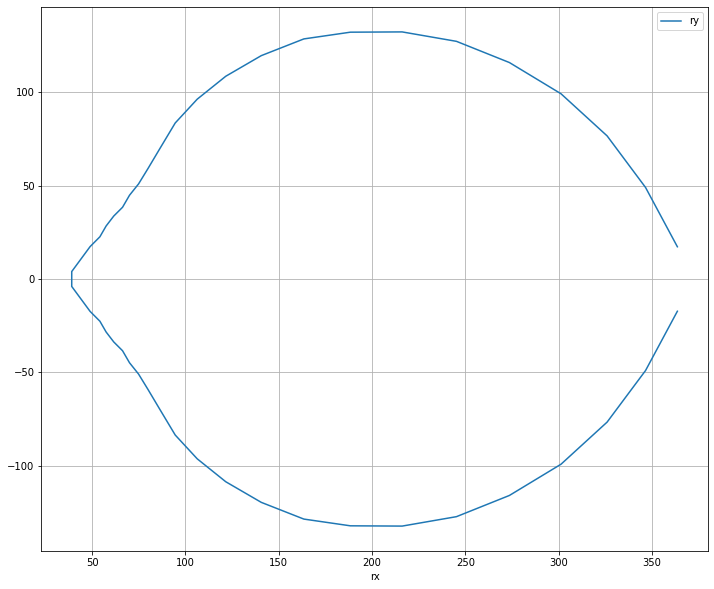

In [ ]:
def multiExperiment2(runnerPos, runnerVelocity, followerPosA, followerPosB, followerVelocity):
  count = 48
  deltaAngle = 2 * pi / count
  deltaAngle2 = deltaAngle / 2
  for index in range(count):
    currentAngle = index * deltaAngle + deltaAngle2
    currentVelocity = Vector(runnerVelocity * cos(currentAngle), runnerVelocity * sin(currentAngle))
    meetingPoint = experiment2(runnerPos, currentVelocity, followerPosA, followerPosB, followerVelocity)
    yield meetingPoint


results = list(multimap(multiExperiment2(Vector(100, 0), 14.2, Vector(0, 75), Vector(0, -75), 20), **maps))
ax = plotData(results, 'rx', 'ry')
plt.grid(which = 'both')  
plt.gca().set_aspect('equal')